# **TESLA STOCK PREDICTION TERM PROJECT**

# Bringing in the Data

**Download And Import The Source Of Our Data**

In [1]:
!pip install yfinance
import yfinance as yf

**Import All The Libraries Our Models Will Necessitate**

In [57]:
!pip install scikit-learn

In [2]:
!pip install pandas_ta

In [3]:
!pip install keras

In [4]:
!pip install tensorflow

In [5]:
!pip install joblib

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as pta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from keras.utils import timeseries_dataset_from_array
from keras import Sequential
from keras import layers
import sys
from sklearn.metrics import r2_score
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from joblib import dump

2023-10-18 21:55:29.252288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Read in the data, display the resulting raw dataframe, and plot it

In [8]:
tsla = yf.Ticker("TSLA")

# get historical market data
df_raw = tsla.history(start="1980-01-01", end="2023-10-08")
print("Raw Data number of rows: ", df_raw.size)
df_raw.tail()

Raw Data number of rows:  23394


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-10-02 00:00:00-04:00,244.809998,254.279999,242.619995,251.600006,123810400,0.0,0.0
2023-10-03 00:00:00-04:00,248.610001,250.020004,244.449997,246.529999,101985300,0.0,0.0
2023-10-04 00:00:00-04:00,248.139999,261.859985,247.600006,261.160004,129721600,0.0,0.0
2023-10-05 00:00:00-04:00,260.000000,263.600006,256.250000,260.049988,119159200,0.0,0.0
2023-10-06 00:00:00-04:00,253.979996,261.649994,250.649994,260.529999,117947000,0.0,0.0


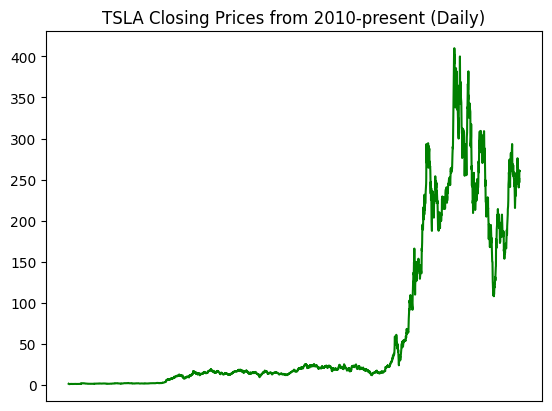

In [9]:
plt.plot(df_raw.index, df_raw['Close'], '-g')
plt.title('TSLA Closing Prices from 2010-present (Daily)')
plt.gca().axes.get_xaxis().set_visible(False)

# Data Preprocessing

**Reducing The Rows**

Initially, I believed reducing the rows of the dataframe might be in our best interest for this project, since at the time of writing this, the rows total to about 3100 entries representing the 3100 or so days since the time that TSLA stock made its Initial Public Offering (IPO) as a publicly traded company on the New York Stock Exchange (NYSE) which seemed to be a lot for my models to handle. However, in hindsight, it turns out using the full history of the stock does not take an unreasonable amount of time, so I'll keep the data in days as opposed to weeks/months/years/whatever.

In the future, however, if there's too many days in the all-time history of TSLA stock, I offer the following datasets and their plots for further use in this project (skip the rest of this subsection if it doesn't apply to the situation at the time you're reading this):

In [10]:
print("Default Daily Data number of rows: ", len(df_raw.index))
df_weekly = df_raw.iloc[::7, :]
print("Weekly Data number of rows: ", len(df_weekly.index))
df_monthly = df_raw.iloc[::30, :]
print("Monthly Data number of rows: ", len(df_monthly.index))
df_bi_monthly = df_raw.iloc[::60, :]
print("Bi-Monthly Data number of rows: ", len(df_bi_monthly.index))
df_tri_monthly = df_raw.iloc[::90, :]
print("Tri-Monthly Data number of rows: ", len(df_tri_monthly.index))
df_half_yearly = df_raw.iloc[::182, :]
print("Half-Yearly Data number of rows: ", len(df_half_yearly.index))
df_yearly = df_raw.iloc[::365, :]
print("Yearly Data number of rows: ", len(df_yearly.index))

Default Daily Data number of rows:  3342
Weekly Data number of rows:  478
Monthly Data number of rows:  112
Bi-Monthly Data number of rows:  56
Tri-Monthly Data number of rows:  38
Half-Yearly Data number of rows:  19
Yearly Data number of rows:  10


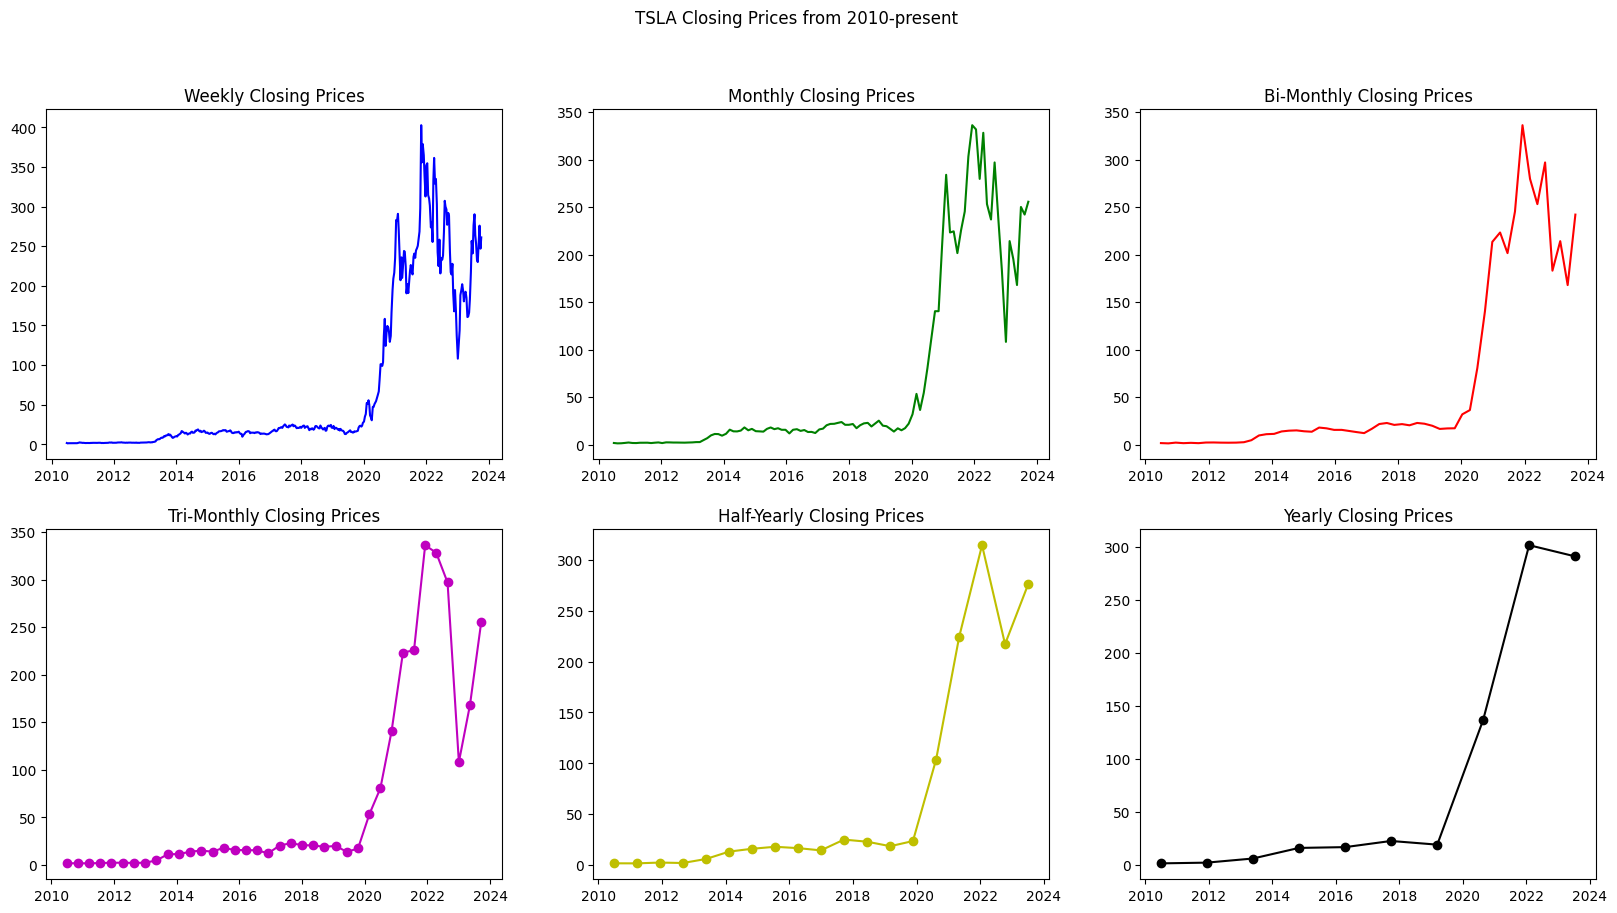

In [11]:
# Set plot heights/widths
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
# Weekly Subplot
plt.subplot(2,3,1)
plt.plot(df_weekly.index,df_weekly['Close'],'-b')
plt.title('Weekly Closing Prices')
# Monthly Subplot
plt.subplot(2,3,2)
plt.plot(df_monthly.index,df_monthly['Close'],'-g')
plt.title('Monthly Closing Prices')
# Bi-Monthly Subplot
plt.subplot(2,3,3)
plt.plot(df_bi_monthly.index,df_bi_monthly['Close'],'-r')
plt.title('Bi-Monthly Closing Prices')
# Tri-Monthly Subplot
plt.subplot(2,3,4)
plt.plot(df_tri_monthly.index,df_tri_monthly['Close'],'-mo')
plt.title('Tri-Monthly Closing Prices')
# Half-Yearly Subplot
plt.subplot(2,3,5)
plt.plot(df_half_yearly.index,df_half_yearly['Close'],'-yo')
plt.title('Half-Yearly Closing Prices')
# Yearly Subplot
plt.subplot(2,3,6)
plt.plot(df_yearly.index,df_yearly['Close'],'-ko')
plt.title('Yearly Closing Prices')
# Set title and overall height/widdth of charts
plt.suptitle('TSLA Closing Prices from 2010-present')
plt.show()

After plotting these intervals and comparing them with the raw data's daily plot, we see the plot that does the best to maintain its trend is the Weekly subset of the data. The yearly closing price looks like an almost comical over-simplification of TSLA's general upwards trend in price over the years. The half-yearly, tri-monthly, and bi-monthly plots do a bit better in progressive order to show the fluctuations in price trends within each year, yet the best among them (bi-monthly) has at most 4 inflection points with insignificant downturns as compared to upward movement which minimizes the true volatility of the stock, especially in recent years. The monthly plot is an improvement and actually surprisingly well in generalizing the volatility of the stock in recent years, yet it still leaves much to be desired by way of longevity of a price range at each point of inflection. Whereas the Monthly plot may have only a single point to represent TSLA's jump in price to just under $300/share in early 2021, the Weekly chart rightfully represents the duration of TSLA stock price at that range over time with 3 consecutive points in the (275,300) interval. Such representational spread of data during volatile shifts in price like this could prove crucial in capturing TSLA's tendancy to fluctuate in valuation for our predictive model, and thus, the weekly data subset at this point in time may be the best to go with if row reduction is necessary

**Reducing The Columns**

As you may have noticed, the two features we plotted in the previous charts were TSLA' adjusted closing price over time (in days). We successfully determined which interval of time to iterate our data over (daily), but why did we choose to plot adjusted closing price as opposed to opening, high, or low price?

Those questions are answered in the following responses regarding each alternative:

*   Opening Price - I could have just as easily chosen TSLA's opening price, yet stock pricing at this time of the trading day tends to be most chaotic. Since it could happen that, after the market's close on the previous day, consequential information regarding a stock's company or the broader economy could get released and cause traders to pre-emptively order the purchase/selling of their stocks, the price of a stock at this time of day to be exaguratted in one way or another and not necessarily representative of its value throughout the duration of it.
*   Price High/Low - The High/Low of a stock on any given trading day is an overly optimistic/pessimistic evaluation of its value of that day. While these could be useful to investors of the same mindset or day traders, I take a more measured long-term approach for the purposes of this project.

Also Note: The 'Close' price column is not synonymous with regular Closing Price, but rather, Adjusted Closing Price. The difference between the two is that *regular* closing price is simply the price per share that the trade of that stock went for, whereas the *adjusted* closing price is that same price, but adjusted to account for dividends/splits/offerings and is thus, the better valuation. (for more info, read https://www.angelone.in/knowledge-center/share-market/difference-between-closing-price-and-adjusted-closing-price#:~:text=While%20closing%20price%20merely%20refers,accurate%20measure%20of%20stocks'%20value.)



In [12]:
df_preprocessed = df_raw.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits'])
df_preprocessed.head()

,Close,Volume
Date,,
2010-06-29 00:00:00-04:00,1.592667,281494500
2010-06-30 00:00:00-04:00,1.588667,257806500
2010-07-01 00:00:00-04:00,1.464000,123282000
2010-07-02 00:00:00-04:00,1.280000,77097000
2010-07-06 00:00:00-04:00,1.074000,103003500


Okay, so we reduced the dataframe to focus on only one price which we determined to be the most indicative of a stock's value. But what about volume? What does that tell/offer us?

Let's see:

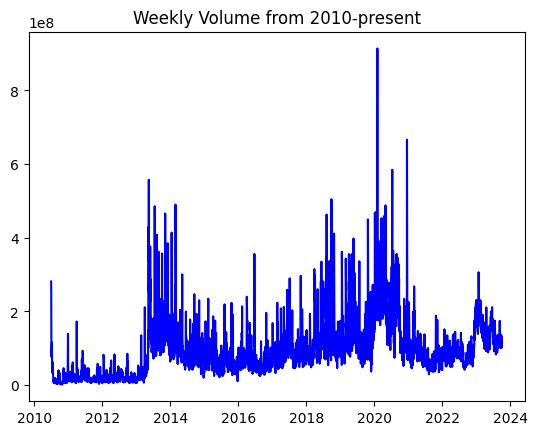

In [13]:
plt.plot(df_preprocessed.index,df_preprocessed['Volume'],'-b')
plt.title('Weekly Volume from 2010-present')
plt.show()

Answer: Volume is a quantitative metric of how many shares are traded on a given day. This could serve as a useful parameter to predict how far a stock's price might move in either direction (Ex: recently negative trend in price && high volume = high probablity of an impending crash in price). So we'll keep it in handy in case it can be used in our future models

Finally, the last feature we might find useful in future price prediction of our TSLA stock is a technical analysis metric called the Relative Strength Index (RSI). This metric calculates the relative strength/weakness of a stock at any point in time based off historical closing prices and is an excellent measure of its realistic fundamental value. As a rule of thumb, RSI > 70 means the stock is overvalued and RSI < 30 means the stock is undervalued. The general idea is given by the following formula:


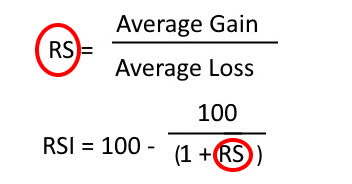

For more details, refer to: https://www.investopedia.com/terms/r/rsi.asp

Now let's add the RSI column and see the head of our final preprocessed dataframe (note that the first 14 or so entries will be NaN since RSI requires 14 previuous closing prices to be calculated):

In [14]:
df_preprocessed['RSI'] = pta.rsi(df_preprocessed['Close'], length = 14)
df_preprocessed['RSI'] = df_preprocessed['RSI'].fillna( df_preprocessed['RSI'].mean() )
df_final = df_preprocessed.copy(deep=True)

df_preprocessed.head()

,Close,Volume,RSI
Date,,,
2010-06-29 00:00:00-04:00,1.592667,281494500,53.239359
2010-06-30 00:00:00-04:00,1.588667,257806500,53.239359
2010-07-01 00:00:00-04:00,1.464000,123282000,53.239359
2010-07-02 00:00:00-04:00,1.280000,77097000,53.239359
2010-07-06 00:00:00-04:00,1.074000,103003500,53.239359


And plot RSI over time to see when TSLA looked over/under-valued (above 70 or under 30, respectively):

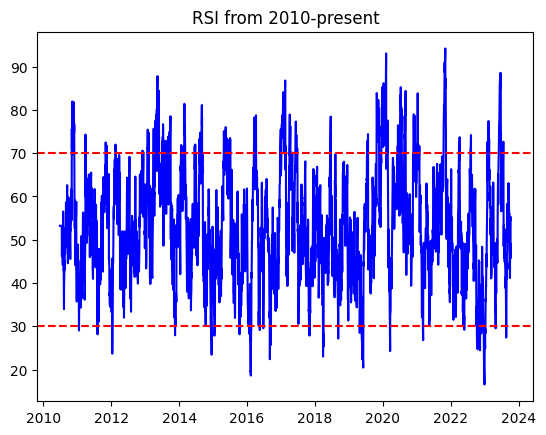

In [15]:
plt.plot(df_preprocessed.index,df_preprocessed['RSI'],'-b')
plt.axhline(y = 70, color = 'r', linestyle = '--')
plt.axhline(y = 30, color = 'r', linestyle = '--')
plt.title('RSI from 2010-present')

plt.show()

# Linear Regression

Our first model for evaluating the our preprocessed dataset will be a linear regression model. While this model may be rather primitive for the purposes of predicting stock price on a day-by-day basis, there may be some merit in evaluating overall future trending of a stock which we'll investigate. we begin by spliting our data 80/20 for training/testing

In [16]:
df_linreg = df_preprocessed.copy(deep=True)
x = df_linreg.index.values
y = df_linreg['Close'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5)

Plot the linear regression in black and actual prices over time in blue

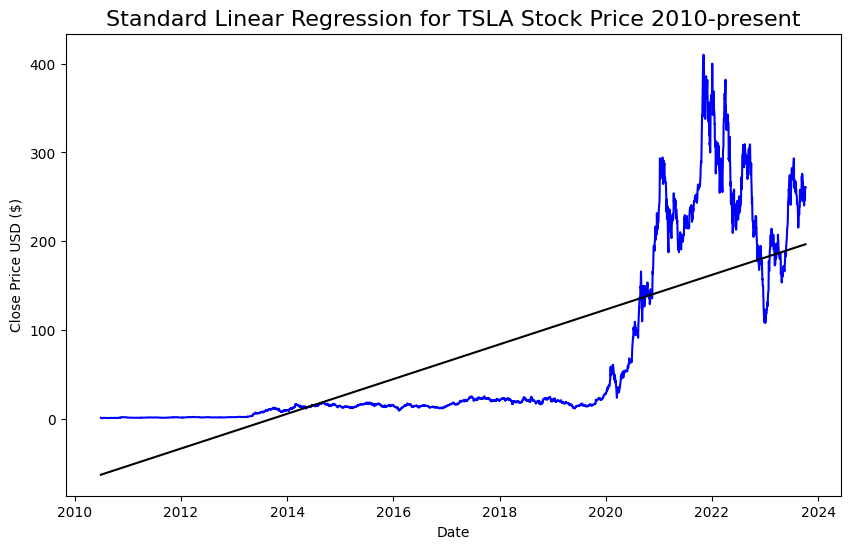

In [17]:
lin = PolynomialFeatures(degree=1, include_bias=False)
train_linear_features = lin.fit_transform(x_train.reshape(-1, 1))
test_linear_features = lin.fit_transform(x_test.reshape(-1, 1))
all_linear_features = lin.fit_transform(x.reshape(-1, 1))

lr_model = LinearRegression()
lr_model.fit(train_linear_features, y_train)
lin_train_predicted = lr_model.predict(train_linear_features)
lin_test_predicted = lr_model.predict(test_linear_features)
y_predicted = lr_model.predict(all_linear_features)
df_linreg['Standard Linear'] = y_predicted
df_final['Standard Linear'] = y_predicted

plt.figure(figsize=(10, 6))
plt.title("Standard Linear Regression for TSLA Stock Price 2010-present", size=16)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(x, y, '-b')
plt.plot(x, df_linreg['Standard Linear'], c="k")
plt.show()

In [18]:
# Assuming your model is named 'model' and has been trained
dump(lr_model, 'models/lin_reg.joblib')

['models/lin_reg.joblib']

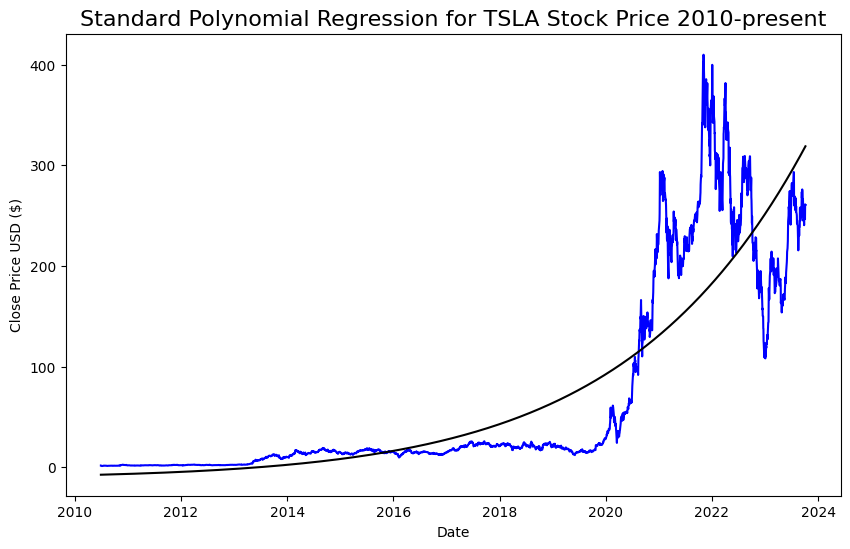

In [19]:
poly = PolynomialFeatures(degree=16, include_bias=False)
train_poly_features = poly.fit_transform(x_train.reshape(-1, 1))
test_poly_features = poly.fit_transform(x_test.reshape(-1, 1))
all_poly_features = poly.fit_transform(x.reshape(-1, 1))

poly_reg_model = LinearRegression()
poly_reg_model.fit(train_poly_features, y_train)
poly_train_predicted = poly_reg_model.predict(train_poly_features)
poly_test_predicted = poly_reg_model.predict(test_poly_features)
y_predicted = poly_reg_model.predict(all_poly_features)
df_linreg['Standard Polynomial'] = y_predicted
df_final['Standard Polynomial'] = y_predicted

plt.figure(figsize=(10, 6))
plt.title("Standard Polynomial Regression for TSLA Stock Price 2010-present", size=16)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(x, y, '-b')
plt.plot(x, df_linreg['Standard Polynomial'], c="k")
plt.show()

Clearly, the line following the closing price and our linear regression model look quite different. It even seems to predict negative stock value for the years before 2014 (very unlikely to put it mildly). But let's examine the error between the predicted values and actual values to see just how different.

In [20]:
# Assuming your model is named 'model' and has been trained
dump(poly_reg_model, 'models/poly_reg.joblib')

['models/poly_reg.joblib']

**Standard Linear/Polynomial Performance Evaluation**

To do this, we'll use Mean Squared Error (MSE):

<div>
<img src="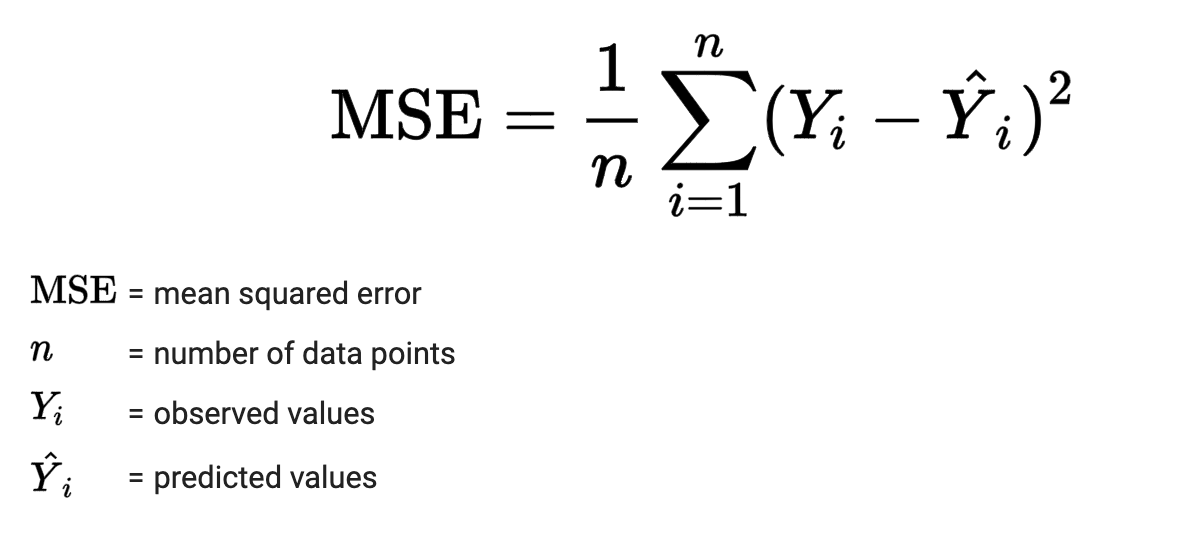
" width="500"/>
</div>

In [21]:
lin_train_mse = mean_squared_error(y_train, lin_train_predicted)
lin_test_mse = mean_squared_error(y_test, lin_test_predicted)
print("Standard LinearRegression model's Training MSE:", lin_train_mse)
print("Standard LinearRegression model's Testing MSE:", lin_test_mse)

poly_train_mse = mean_squared_error(y_train, poly_train_predicted)
poly_test_mse = mean_squared_error(y_test, poly_test_predicted)
print("\nStandard PolynomialRegression model's Training MSE:", poly_train_mse)
print("Standard PolynomialRegression model's Testing MSE:", poly_test_mse)

Standard LinearRegression model's Training MSE: 4141.67488999971
Standard LinearRegression model's Testing MSE: 4506.0559706385975

Standard PolynomialRegression model's Training MSE: 2450.1906981819297
Standard PolynomialRegression model's Testing MSE: 2628.1911644975617


As we can see, the error for our standard Linear Regression model is enormous. Depending on what a model is trying to accomplish (critical tasks like self-driving cart programs require very small error whereas tasks like predicting weather can have more), a reasonable MSE would be somewhere around the range [0,10]. Our linear regression and polynomial regression models exceed this range by factors of around 400x and 150x (in testing mse), respectively.

However, these big MSE values are a bit hard to read and evaluate on a limited standardized scale, so we can also use each model's coefficient of determination which is limited by a lowest value of 0.0 meaning the model's prediction values represent a constant line with no fluctuation toward the trends of the data whatsoever and a highest value of 1.0 meaning each value is predicted exactly correctly by our model. The formula for coefficient of determination is given by the following:

<div>
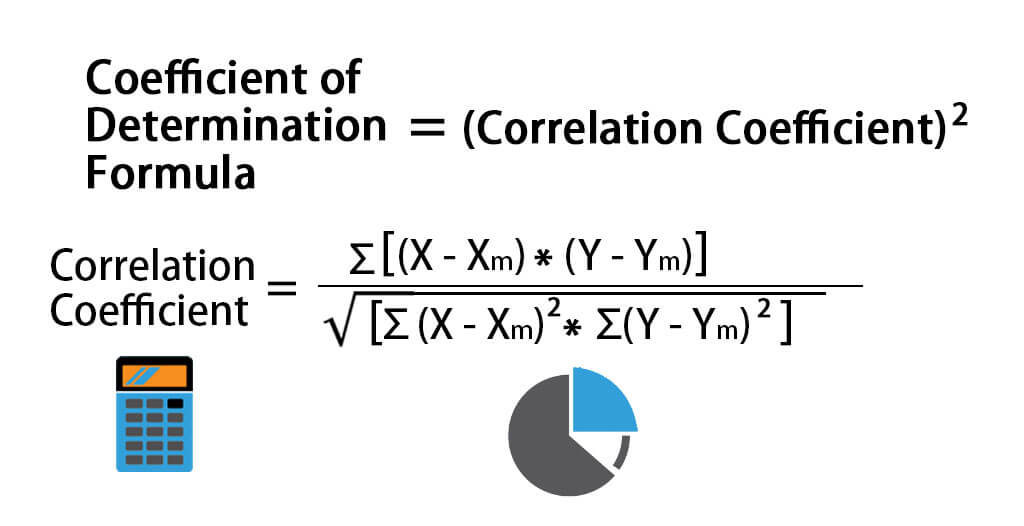
</div>

In [22]:
x_train_float = x_train.astype(np.float64)
x_test_float = x_test.astype(np.float64)

print("Standard LinearRegression model's Training Coefficient of Determination:", lr_model.score(x_train_float.reshape(-1, 1),y_train))
print("Standard LinearRegression model's Testing Coefficient of Determination:", lr_model.score(x_test_float.reshape(-1, 1),y_test))

print("\nStandard PolynomialRegression model's Training Coefficient of Determination:", poly_reg_model.score(train_poly_features,y_train))
print("Standard PolynomialRegression model's Testing Coefficient of Determination:", poly_reg_model.score(test_poly_features,y_test))

Standard LinearRegression model's Training Coefficient of Determination: 0.5755162667290442
Standard LinearRegression model's Testing Coefficient of Determination: 0.5849623762997431

Standard PolynomialRegression model's Training Coefficient of Determination: 0.7488779002665494
Standard PolynomialRegression model's Testing Coefficient of Determination: 0.7579261725440816


Now that the metric is standardized as we stated previously, we can see that the linear regressor is truly abysmal with a value only aproaching arond 0.5 (the halfway point between perfect prediction of values and the worst predictive ability possible). We can also see that the PolynomialRegression has a bit more respectable of a predictive ability with a testing correlation coefficient of around 0.8 and a range of only 0.21 left to grow into to reach closer to the perfect 1.0 value. Let's see if we can achieve this through hyperparameter manipulation on this regression model:

**Tuning The Model**

The two ways we'll attempt to tune our Regression model to achieve better prediction value results is with LASSO and Ridge Rergression.

LASSO (Least Absolute Shrinkage and Selection Operator) is used to regularize parameters according to their importance in predicting the desired values and essentially select the right ones among them to do so. This is done by introducing a penalization factor called alpha to shrink the parameters down to a central point rather than calculate them raw. It also serves to reduce model completxity (lower value parameters factor less into calculations and reveal which ones matter the most):

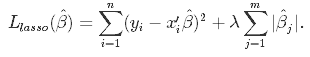

Ridge Regression puts a similar penalizing constraint on the coefficients of the predictive line's equation, however, while LASSO does this by computing the magnitude of the coefficients, ridge regression takes the square.

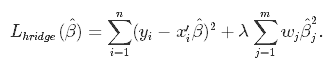

LASSO Regressor:

In [23]:
#Build first LASSO Regression with default hyperparameter values
lasso = Lasso(alpha = 1, tol=0.0001, max_iter=1000)
lasso.fit(train_poly_features, y_train)
y_predicted = lasso.predict(all_poly_features)
df_linreg['Default LASSO'] = y_predicted
df_final['Default LASSO'] = y_predicted

train_score_ls =lasso.score(train_poly_features, y_train)
test_score_ls =lasso.score(test_poly_features, y_test)
print("Default LASSO PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ls))
print("Default LASSO PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ls))

/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: RuntimeWarning: overflow encountered in square
  model = cd_fast.enet_coordinate_descent(


Default LASSO PolynomialRegression model's Training Coefficient of Determination 0.7648584526912535
Default LASSO PolynomialRegression model's Testing Coefficient of Determination 0.7761307366250579


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+06, tolerance: 2.608e+03
  model = cd_fast.enet_coordinate_descent(


Save the first Lasso

In [24]:
# Assuming your model is named 'model' and has been trained
dump(lasso, 'models/default_lasso.joblib')

['models/default_lasso.joblib']

This score is definitely an improvement, but lets see if tuning the parameters by increasing the maximum number of iterations for training, decreasing the tolerance for optimization, and increasing our alpha value won't produce better results:

In [25]:
#Build LASSO Regression with tuned hyperparameter values
lasso = Lasso(alpha = 10, tol=0.0000001, max_iter=1000000)
lasso.fit(train_poly_features, y_train)
y_predicted = lasso.predict(all_poly_features)
df_linreg['Tuned LASSO'] = y_predicted
df_final['Tuned LASSO'] = y_predicted

train_score_ls =lasso.score(train_poly_features, y_train)
test_score_ls =lasso.score(test_poly_features, y_test)
print("Tuned LASSO PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ls))
print("Tuned LASSO PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ls))

/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: RuntimeWarning: overflow encountered in square
  model = cd_fast.enet_coordinate_descent(


Tuned LASSO PolynomialRegression model's Training Coefficient of Determination 0.7790103538934159
Tuned LASSO PolynomialRegression model's Testing Coefficient of Determination 0.790134624559562


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.882e+06, tolerance: 2.608e+00
  model = cd_fast.enet_coordinate_descent(


As we can see, this improved the model's prediction ability quite a bit (+0.08 in training data prediction accuracy and +0.07 in testing data prediction accuracy) from the standard PolynomialRegression. Let's see what it looks like plotted out

In [26]:
# Assuming your model is named 'model' and has been trained
dump(lasso, 'models/tuned_lasso.joblib')

['models/tuned_lasso.joblib']

Text(0, 0.5, 'Close Price USD ($)')

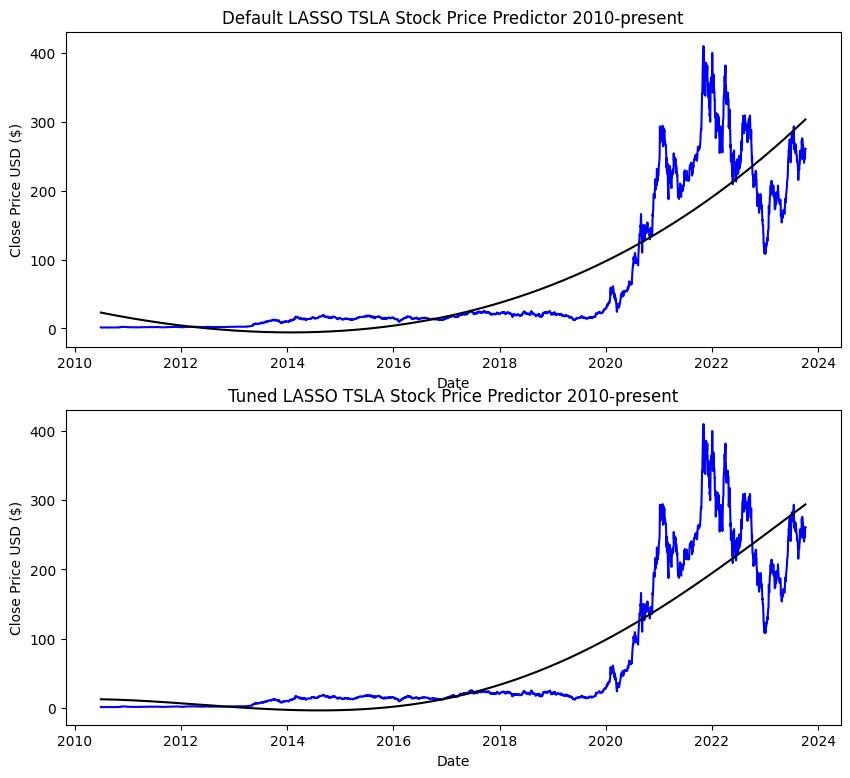

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(10, 9))
axs[0].plot(x, y, '-b')
axs[0].plot(x, df_linreg['Default LASSO'], c="k")
axs[0].set_title('Default LASSO TSLA Stock Price Predictor 2010-present')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close Price USD ($)')
axs[1].plot(x, y, '-b')
axs[1].plot(x, df_linreg['Tuned LASSO'], c="k")
axs[1].set_title('Tuned LASSO TSLA Stock Price Predictor 2010-present')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Close Price USD ($)')

It looks more dynamic than the Standard PolynomialRegression model, but I'm not so sure if I would trust the future trend of the line so much on the second model. Regardless, let's see if Ridge Regression can do any better:

Ridge Regressor:

With Ridge Regression, though, we need to be a bit more careful with the PolynomialRegression model we're building from. Before, we used a Polynomial Regression with parameters up to the power of 16, which gave us some transformed polynomial features with values as high as 1e+244, but now that the calculations we're using involve squaring such values, we have to reduce their scale. Thus, instead of building our RidgeRegression model from a PolynomialRegression of degree 16, we will be building it from one of degree 5.

In [28]:
#Build first Ridge Regression with default hyperparameter values
ridgeReg = Ridge(alpha = 1, tol=0.001)

poly = PolynomialFeatures(degree=5, include_bias=False)
all_poly_features = poly.fit_transform(x.reshape(-1, 1))
train_poly_features = poly.fit_transform(x_train.reshape(-1, 1))
test_poly_features = poly.fit_transform(x_test.reshape(-1, 1))

ridgeReg.fit(train_poly_features, y_train)
y_predicted = ridgeReg.predict(all_poly_features)
df_linreg['Default Ridge'] = y_predicted
df_final['Default Ridge'] = y_predicted

train_score_ridge = ridgeReg.score(train_poly_features, y_train)
test_score_ridge = ridgeReg.score(test_poly_features, y_test)
print("Default Ridge PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ridge))
print("Default Ridge PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ridge))

Default Ridge PolynomialRegression model's Training Coefficient of Determination 0.8668717606611276
Default Ridge PolynomialRegression model's Testing Coefficient of Determination 0.8884954205298574


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.38767e-158): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Save the Ridge regressor

In [29]:
# Assuming your model is named 'model' and has been trained
dump(ridgeReg, 'models/default_ridge.joblib')

['models/default_ridge.joblib']

In [30]:
#Build Ridge Regression with tuned hyperparameter values
ridgeReg = Ridge(alpha=10, tol=0.0000001, max_iter=1000000)
ridgeReg.fit(train_poly_features,y_train)
y_predicted = ridgeReg.predict(all_poly_features)
df_linreg['Tuned Ridge'] = y_predicted
df_final['Tuned Ridge'] = y_predicted

train_score_ridge = ridgeReg.score(train_poly_features, y_train)
test_score_ridge = ridgeReg.score(test_poly_features, y_test)
print("Tuned Ridge PolynomialRegression model's Training Coefficient of Determination {}".format(train_score_ridge))
print("Tuned Ridge PolynomialRegression model's Testing Coefficient of Determination {}".format(test_score_ridge))

Tuned Ridge PolynomialRegression model's Training Coefficient of Determination 0.8668717606611276
Tuned Ridge PolynomialRegression model's Testing Coefficient of Determination 0.8884954205298574


/Users/vrife/opt/anaconda3/envs/school/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.38767e-158): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [31]:
# Assuming your model is named 'model' and has been trained
dump(ridgeReg, 'models/tuned_ridge.joblib')

['models/tuned_ridge.joblib']

As we can see, this improved the model's prediction ability quite a bit (+0.11 in training data prediction accuracy and +0.09 in testing data prediction accuracy) from the standard PolynomialRegression. And it improved the model's prediction ability from LASSO regression, as well (+0.03 in training data prediction accuracy and +0.01 in testing data prediction accuracy). Let's see how it looks on a plot:

Text(0, 0.5, 'Close Price USD ($)')

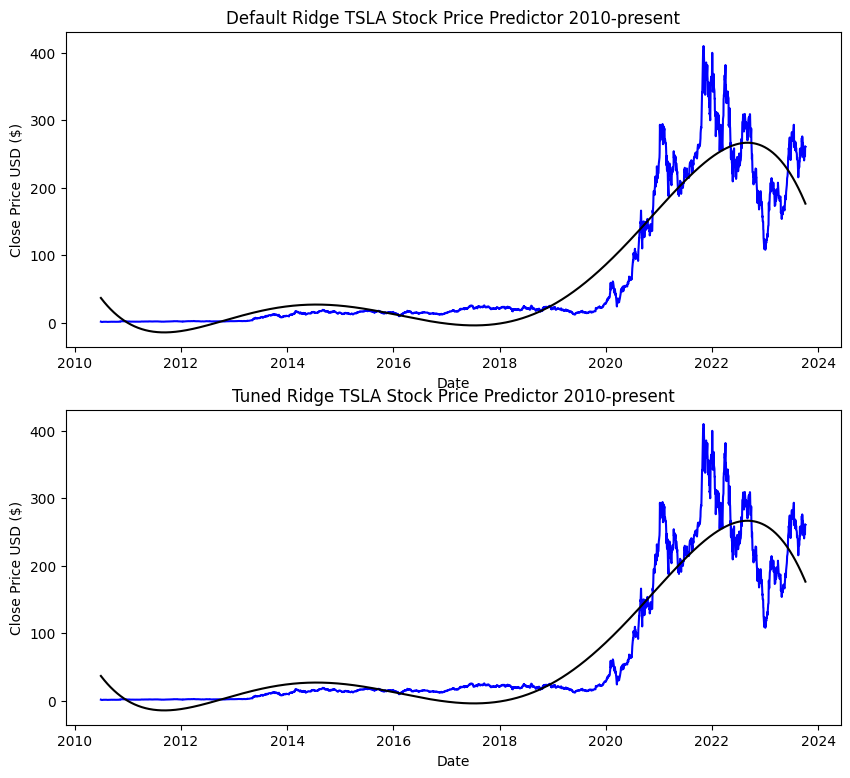

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(10, 9))
axs[0].plot(x, y, '-b')
axs[0].plot(x, df_linreg['Default Ridge'], c="k")
axs[0].set_title('Default Ridge TSLA Stock Price Predictor 2010-present')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close Price USD ($)')
axs[1].plot(x, y, '-b')
axs[1].plot(x, df_linreg['Tuned Ridge'], c="k")
axs[1].set_title('Tuned Ridge TSLA Stock Price Predictor 2010-present')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Close Price USD ($)')

Here, again, we see an improvement in the dynamism of the model, especially in the early years from 2010-2019. However, I would not trust the predictions there since, over the course of two entire years from 2017-2019, you would have thought the stock would dip instead of make steady gains like it did in these years after 2016. But since this is the best we've got so far with our LinearRegression model, this will be our final, best performing one. Let's see if Convolutional Neural Networks can do better:

# Convolutional Neural Net (CNN)

Previously, we used variations of LinearRegression models to predict the prices of TSLA stock through time. While there was some merit in doing so to outline the trend of the price on a very general level, the resulting plots often looked like very crude oversimplifications of tumultuous volatile shifts we hoped to capture in our predictions. The reason for this crude look was, in large part, because of a lack of features in the resulting prediction algorithms. When our closing price data would shift up and down 50 times within a year, our regression models were only able to adjust course at most 16 times over the course of 10 years.

With Neural Networks, however, we have vastly more potential for more features in our algorithm. So many features, in fact, that we might even be able to follow every previously problematic upward/downward turn in our data and compute some interestingly close predictions for data that such a model hasn't yet seen (testing/validation data).

More specifically, we will use a Convolutional Neural Network (CNN) with each closing price point predicted from a model extensively trained through gradient descent using batches of previous points before it (rather than the entirety of our cumbersome dataset which would take way too long for each training epoch). We use a CNN in part, because of efficiency (weight sharing minimizes computation time as compared to regular NNs), and also in part, because it is excellent at identifying and prioritizing important features within the prediction algorithm without human supervision. This means we end up training a model in a way smarter and faster than the alternatives. So let's see what happens:

First, we split our data as before and display the head of our new CNN dataframe:

In [88]:
df_cnn = df_preprocessed.copy(deep=True)
x = df_cnn.index.values
y = df_cnn['Close'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5)
df_cnn.head()

,Close,Volume,RSI
Date,,,
2010-06-29 00:00:00-04:00,1.592667,281494500,53.239359
2010-06-30 00:00:00-04:00,1.588667,257806500,53.239359
2010-07-01 00:00:00-04:00,1.464000,123282000,53.239359
2010-07-02 00:00:00-04:00,1.280000,77097000,53.239359
2010-07-06 00:00:00-04:00,1.074000,103003500,53.239359


We want to create a time series generator that obtains all the features (batches of each date we're predicting's previous dates' prices to use as indicators to compute a prediction of this date's price) for any given date. To keep our model flexible, we will construct the databases with an offset variable of previous days we use to predict a given day's adjusted closing price. Our batch size will be of the size of the entire dataset so it wastes no time and processes it all at once.

In [89]:
def generate_series(series_data, offset):
    dataset = timeseries_dataset_from_array(data=series_data, targets=series_data, sequence_length=offset, batch_size=len(series_data))
    return dataset

Here, we demonstrate the output of the method works as expected

In [90]:
offset = 1
inputs, targets = next(iter(generate_series(df_cnn['Close'], offset).take(1)))

# Split our data into train/test sets for our inputs and targets
train_inputs = inputs[:-len(y_test)]
val_inputs = inputs[-len(y_test):]
train_targets = targets[:-len(y_test)]
val_targets = targets[-len(y_test):]

print("total days:", len(inputs))
print("2999th day's input features sequence:", inputs[2999])
print("2999th day's target value:", targets[2999])

total days: 3342
2999th day's input features sequence: tf.Tensor([235.91000366], shape=(1,), dtype=float64)
2999th day's target value: tf.Tensor(235.91000366210938, shape=(), dtype=float64)


And here, we make a method to build a cnn model with two intermediary layers consisting of 64 neurons using the ReLU function as their activation function before outputing a final prediction value in the last single output layer:

In [91]:
def create_model(n):
    m = Sequential()
    m.add(layers.Dense(64, activation='relu', input_shape=(n,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(1))
    return m

We can handle splitting the data into test/training data, building multiple CNN models to have a selection to choose from, and training them before showing us information about each one all in a seperate method, too:

In [92]:
def explore_inputs(series_data, start, end, epochs, offset):
    models = {}
    for inputs in range(start, end+1):
        print('Using {} inputs'.format(inputs))
        model_inputs, targets = next(iter(generate_series(series_data, offset).take(1)))

        # Split our data into train/test sets for our inputs and targets
        train_inputs = model_inputs[:-len(y_test)]
        val_inputs = model_inputs[-len(y_test):]
        train_targets = targets[:-len(y_test)]
        val_targets = targets[-len(y_test):]

        m = create_model(offset)
        print('Training')
        m.compile(optimizer='adam', loss='mse')
        h = m.fit(train_inputs, train_targets,
                  epochs=epochs,
                  batch_size=32,
                  validation_data=(val_inputs, val_targets))
        model_info = {'model': m, 'history': h.history}
        models[inputs] = model_info
    return models

Now that we have all that out of the way, let’s train 9 seperate networks with 2 to 10 inputs for 20 epochs with a number of features equivalent to however many days we set previously to our "offset" variable to see which number of inputs (hyperparameter) gives us the best model:

In [93]:
trained_models = explore_inputs(df_cnn['Close'], 2, 10, 20, offset)

Using 2 inputs
Training
Epoch 1/20


84/84 [==============================] - 2s 6ms/step - loss: 353.2153 - val_loss: 3.4022
Epoch 2/20
84/84 [==============================] - 0s 3ms/step - loss: 0.0809 - val_loss: 0.1898
Epoch 3/20
84/84 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.1215
Epoch 4/20
84/84 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.1265
Epoch 5/20
84/84 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.0380
Epoch 6/20
84/84 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.1188
Epoch 7/20
84/84 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 8/20
84/84 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0257
Epoch 9/20
84/84 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 10/20
84/84 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 11/20
84/84 [=========

For a clearer picture, we print out the final resulting training/testing MSE loss of those models:

In [94]:
model_stats = {}
min_loss = sys.maxsize
best_model_key = 0
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss': val_loss}

    # If this model's validation loss is better than the best, set this
    # as the best model and minimum loss
    if val_loss < min_loss:
      min_loss = val_loss
      best_model_key = k
for k, v in model_stats.items():
    print(k, v)

2 {'inputs': 2, 'loss': 1.236535240423109e-06, 'val_loss': 1.8434858475302462e-06}
3 {'inputs': 3, 'loss': 4.0381251120713557e-10, 'val_loss': 2.924304132179145e-10}
4 {'inputs': 4, 'loss': 1.075411093509615e-09, 'val_loss': 2.6560615928872267e-09}
5 {'inputs': 5, 'loss': 4.703508338366191e-08, 'val_loss': 1.2433304164005676e-07}
6 {'inputs': 6, 'loss': 1.017298927763477e-06, 'val_loss': 4.706152594735613e-06}
7 {'inputs': 7, 'loss': 5.908665343667963e-07, 'val_loss': 3.870692921736918e-07}
8 {'inputs': 8, 'loss': 3.276417999131809e-07, 'val_loss': 3.397476859845483e-07}
9 {'inputs': 9, 'loss': 4.104407480554073e-07, 'val_loss': 7.617206847498892e-07}
10 {'inputs': 10, 'loss': 4.1561079910934495e-08, 'val_loss': 2.5025769900821615e-07}


As we can see, the error computed with the test set is always slightly greater than the value computed for the train set. This means that the network handles known data (training examples) slightly better than unknown (test examples), which is expected. What matters most here is which model ended its last epoch of training with the least testing/validation loss (val_loss), since that model is best generalized to data it's never seen before. So let's determine which model that is, plot it's predictions, and see how close they get

In [95]:
best_model = trained_models[best_model_key]['model']
y_predicted = best_model.predict(inputs)

# The following adjustments are made because y_predicted is a list of lists and
# it also does not contain the first 30 or last 30 predicted values due to the
# nature of our computations, so this column must be shifted down
y_predicted = [item for sublist in y_predicted for item in sublist]
# offset_column = [np.nan] * (offset-1)
# y_predicted.extend(offset_column)
df_cnn['Convolutional Neural Network'] = y_predicted
df_final['Convolutional Neural Network'] = y_predicted

 62/105 [================>.............] - ETA: 0s

105/105 [==============================] - 0s 3ms/step


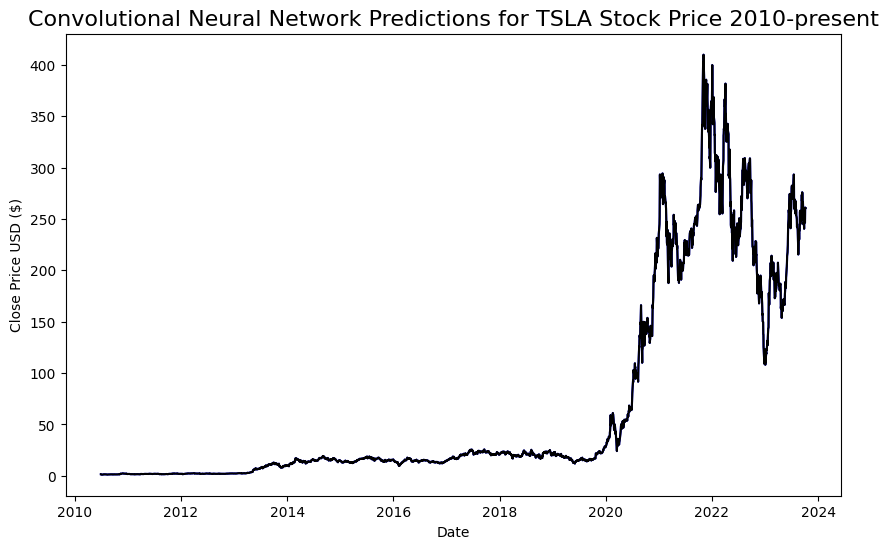

In [96]:
plt.figure(figsize=(10, 6))
plt.title("Convolutional Neural Network Predictions for TSLA Stock Price 2010-present", size=16)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(x, y, '-b')
plt.plot(x, df_cnn['Convolutional Neural Network'], c="k")
plt.show()

Wow! Those lines look extremely close. Too close to distinguish from one another. Instead of looking at how closely our predictions matches with the entirety off the true closing price plot, let's specifically evaluate how close the validation set predictions are to their true values and draw the two with clearly distinguishable colors and a legend:

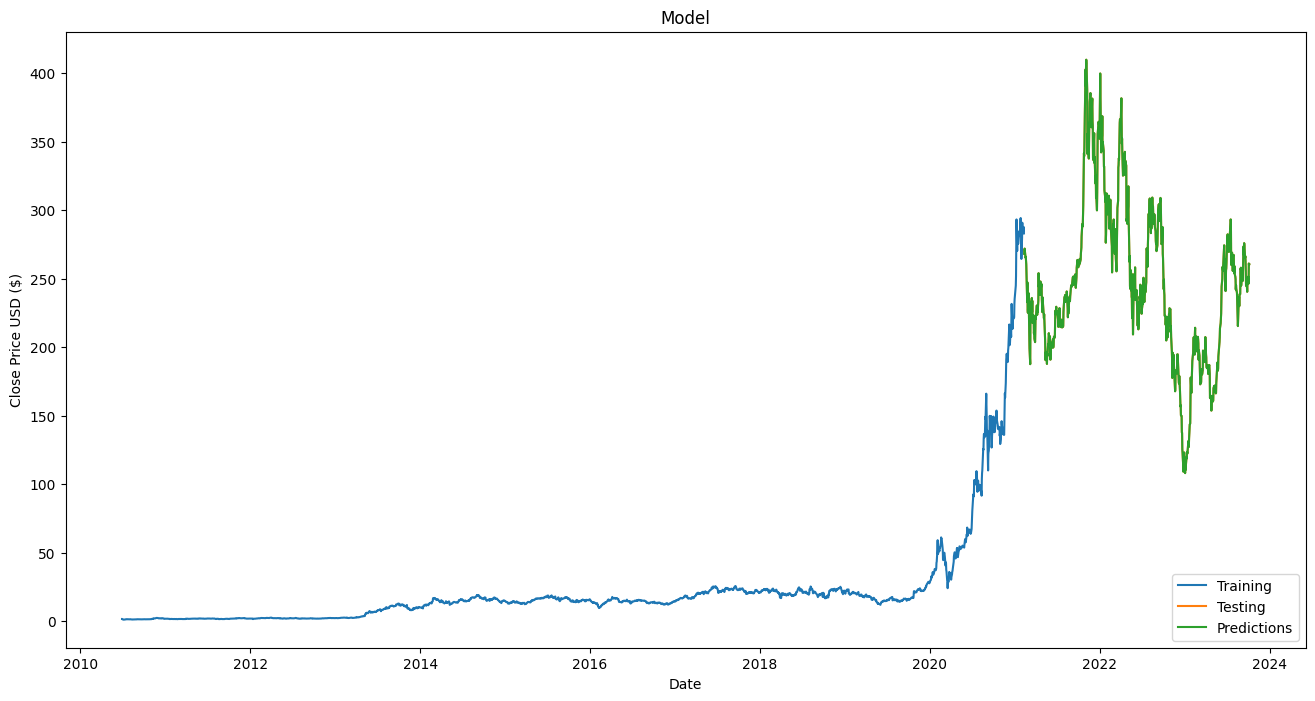

In [97]:
data = df_cnn.filter(['Close'])
train = data[:len(x_train)]
# predictions = best_model.predict(val_inputs)

validation = df_cnn[len(x_train):]
# validation['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Convolutional Neural Network']])
plt.legend(['Training', 'Testing', 'Predictions'], loc='lower right')
plt.show()

Slightly more distinguishable now, but still too close to get a real feel for our predictions' accuracy. Lets compute the Coefficient of Determination like we did for our Linear Regression models before to truly understand how much closer to a perfect value of 1 it gets

In [98]:
train = df_cnn['Close'][:-len(y_test)]
test = df_cnn['Close'][-len(y_test):]
train_pred = df_cnn['Convolutional Neural Network'][:-len(y_test)]
test_pred = df_cnn['Convolutional Neural Network'][-len(y_test):]

#Training score is offset due to the first few prediction prices being NaN
train_score_cnn = r2_score(train[(offset-1):], train_pred[(offset-1):])
test_score_cnn = r2_score(test, test_pred)
print("CNN's Training Coefficient of Determination {}".format(train_score_cnn))
print("CNN's Testing Coefficient of Determination {}".format(test_score_cnn))

CNN's Training Coefficient of Determination 0.9999999999997488
CNN's Testing Coefficient of Determination 0.9999999999999128


Here we can clearly see the power of Neural Networks. Where before, we could only get a coefficient of determination no higher than 0.88269221130068 with our best Tuned Ridge Regression model, now we're able to get just under 0.05 of an R2 score from the perfect goal value of 1.0

Now you're probably thinking: How can we possibly get any closer to the true values to get to such a score after having computed such an accurate model with CNNs already?

The answer is in our next section: LSTMs

In [99]:
# best_model.save('models/cnn.h5')
best_model.save('models/cnn')

INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


# Long Short-Term Memory Recursive Neural Net (LSTM RNN)

To recap, so far, we have made a LinearRegression, PolynomialRegression, LASSO Regression, Ridge Regression, and Convolutional Neural Network model. As we saw, the regression models did an alright job of following the general trend, with our best Ridge Regression version of those models getting to a decent coefficient of determination of 0.88269221130068. Then, we used the power of Neural Networks and our CNN model's many features to produce a shockingly accurate plot of predicted values and significantly better coefficient of determination of 0.952587234206071. Now, we want to shoot even higher with a special kind of Neural Network called a Long Short-Term Memory Recurrent Neural Network (LSTM for short).

The "Recurrent Neural Network" part of this model's name means an LSTM is not only limited to feedforward connections between its parameters' neurons like a standard CNN is, but its neurons also have feedback connections which are capable of processing entire sequences of data recurrently.

Furthermore, the "Long Short-Term Memory" part of this model's name refers to the analogy that a standard RNN has both "long-term memory" and "short-term memory" of previously fed data. Long-term memory in the sense that the neuron weights and biases in the network change once per *episode* of training, and short-term memory in the sense that the activation patterns in the network change once per *time-step* within an episode of training. However, unlike standard RNNs, an LSTM regulates the memory of previously fed data with four "gates" in every neuron whose computations are visualized in the following:

<div>
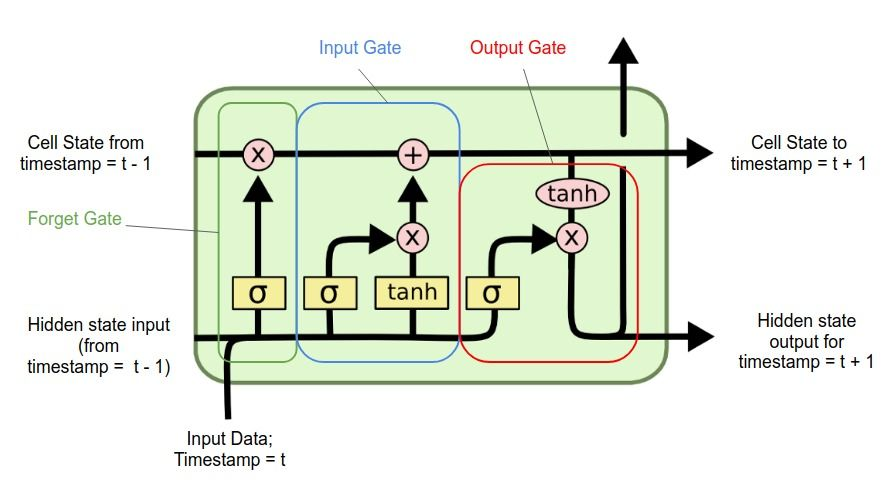
</div>

Suffice to say, where previously, we did not regulate the impact of data fed into the prior prediction computations of our model (its memory), now we will. Let's see how this tailored approach does with predicting TSLA stock by, once again, initializing the x/y values to start:

In [120]:
df_lstm = df_preprocessed.copy(deep=True)
df_lstm['RSI'] = df_lstm['RSI'].fillna(0)
x = df_lstm.index.values
y = df_lstm['Close'].values

Now, we reshape and split the closing price data 80/20 before assigning the training/testing targets and inputs similar to how we did with the CNN before (though a bit trickier this time). However, this time, we'll scale the data to a [0,1] range so our model's long memory isn't skewed by an overwhelming price value in either direction during training. We'll also wrap this process in a method to be called upon for the many models we'll build to minimize code repetition of this new spliting process

In [121]:
def data_split(y, scaler, offset):
  training_data_len = math.ceil(len(y)* 0.8)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(y.reshape(-1,1))

  train_data = scaled_data[0: training_data_len, :]
  x_train = []
  y_train = []
  for i in range(offset, len(train_data)):
      x_train.append(train_data[i-offset:i, 0])
      y_train.append(train_data[i, 0])
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  test_data = scaled_data[training_data_len-offset: , : ]
  x_test = []
  y_test = scaled_data[training_data_len:]
  for i in range(offset, len(test_data)):
    x_test.append(test_data[i-offset:i, 0])
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

  return x_train, y_train, x_test, y_test

Similarly, we assign the testing targets (y_test) and inputs (x_test)

In [124]:
offset = 30
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(y.reshape(-1,1))
x_train, y_train, x_test, y_test = data_split(y, scaler, offset)

Now we build and train the LSTM models with methods similar to how we did with our CNN

In [125]:
def create_model(n):
  m = keras.Sequential()
  m.add(layers.LSTM(100, return_sequences=True, input_shape=(n, 1)))
  m.add(layers.LSTM(100, return_sequences=False))
  m.add(layers.Dense(25))
  m.add(layers.Dense(1))
  return m

def explore_inputs(y, start, end, epochs, scaler, offset):
  models = {}
  for inputs in range(start, end+1):
    print('Using {} inputs'.format(inputs))

    # Split our data into train/test sets for our inputs and targets
    train_inputs, train_targets, val_inputs, val_targets = data_split(y, scaler, offset)

    m = create_model(train_inputs.shape[1])
    print('Training')
    m.compile(optimizer='adam', loss='mean_squared_error')
    h = m.fit(train_inputs, train_targets,
                  epochs=epochs,
                  batch_size= 1,
                  validation_data=(val_inputs, val_targets))
    model_info = {'model': m, 'history': h.history}
    models[inputs] = model_info
  return models

In [126]:
trained_models = explore_inputs(y, 2, 10, 3, scaler, offset)

Using 2 inputs
Training
Epoch 1/3
2644/2644 [==============================] - 240s 87ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 2/3
2644/2644 [==============================] - 270s 102ms/step - loss: 2.3947e-04 - val_loss: 0.0068
Epoch 3/3
2644/2644 [==============================] - 223s 84ms/step - loss: 3.1617e-04 - val_loss: 0.0010
Using 3 inputs
Training
Epoch 1/3
2644/2644 [==============================] - 218s 80ms/step - loss: 8.2791e-04 - val_loss: 0.0115
Epoch 2/3
2644/2644 [==============================] - 238s 90ms/step - loss: 2.8500e-04 - val_loss: 0.0045
Epoch 3/3
2644/2644 [==============================] - 258s 98ms/step - loss: 2.1143e-04 - val_loss: 0.0036
Using 4 inputs
Training
Epoch 1/3
2644/2644 [==============================] - 239s 88ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 2/3
2644/2644 [==============================] - 237s 90ms/step - loss: 2.9089e-04 - val_loss: 0.0012
Epoch 3/3
2644/2644 [==============================] - 225s 85ms/step -

Compare the training and validation loss of each model

In [127]:
model_stats = {}
min_loss = sys.maxsize
best_model_key = 0
for k, v in trained_models.items():
    train_history = v['history']
    loss = train_history['loss'][-1]
    val_loss = train_history['val_loss'][-1]
    model_stats[k] = {'inputs': k, 'loss': loss, 'val_loss': val_loss}

    # If this model's validation loss is better than the best, set this
    # as the best model and minimum loss
    if val_loss < min_loss:
      min_loss = val_loss
      best_model_key = k
for k, v in model_stats.items():
    print(k, v)

2 {'inputs': 2, 'loss': 0.00031617446802556515, 'val_loss': 0.0010472836438566446}
3 {'inputs': 3, 'loss': 0.00021142829791642725, 'val_loss': 0.0036498340778052807}
4 {'inputs': 4, 'loss': 0.00047938997158780694, 'val_loss': 0.00085121562005952}
5 {'inputs': 5, 'loss': 0.00024569415836595, 'val_loss': 0.00938795879483223}
6 {'inputs': 6, 'loss': 0.00025510898558422923, 'val_loss': 0.00336638861335814}
7 {'inputs': 7, 'loss': 0.00020795129239559174, 'val_loss': 0.0028112081345170736}
8 {'inputs': 8, 'loss': 0.0002583076129667461, 'val_loss': 0.0007760566659271717}
9 {'inputs': 9, 'loss': 0.0002601016021799296, 'val_loss': 0.0006931580137461424}
10 {'inputs': 10, 'loss': 0.00015441492723766714, 'val_loss': 0.0007056054309941828}


Create an LSTM predictions column for all our LSTM model's predictions across both training and testing data

In [128]:
best_model = trained_models[best_model_key]['model']

x = np.concatenate((x_train, x_test))
pred = best_model.predict(x)
pred = scaler.inverse_transform(pred)
pred = [item for sublist in pred for item in sublist]
pred_column = [np.nan] * offset
pred_column.extend(pred)

df_lstm['LSTM'] = pred_column
df_final['LSTM'] = pred_column

104/104 [==============================] - 6s 38ms/step


Compute the coefficient of determination to see how well the LSTM model performed with the training/testing data

In [129]:
train = df_lstm['Close'][:-len(y_test)]
test = df_lstm['Close'][-len(y_test):]
train_pred = df_lstm['LSTM'][:-len(y_test)]
test_pred = df_lstm['LSTM'][-len(y_test):]

#Training score is offset due to the first few prediction prices being NaN
train_score_lstm = r2_score(train[(offset):], train_pred[(offset):])
test_score_lstm = r2_score(test, test_pred)
print("LSTM's Training Coefficient of Determination {}".format(train_score_lstm))
print("LSTM's Testing Coefficient of Determination {}".format(test_score_lstm))

LSTM's Training Coefficient of Determination 0.9959961485591582
LSTM's Testing Coefficient of Determination 0.965858009047979


And as we can see, this LSTM model performs better than all the other models including the CNN in the previous section. The model is a value of only 0.01 away from a perfect 1.0 value on the training data and a shocking 0.02 away from the same perfect coeficient of determination value on the testing data. Surely, this is the best we've seen so far, so let's see how close the testing predictions are on a graph similar to the one we made for the CNN:

 7/21 [=========>....................] - ETA: 0s

21/21 [==============================] - 1s 29ms/step


/var/folders/7l/g723v03x3mnf7k1pbk2jwrzm0000gn/T/ipykernel_52800/640846472.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = lstm_predictions


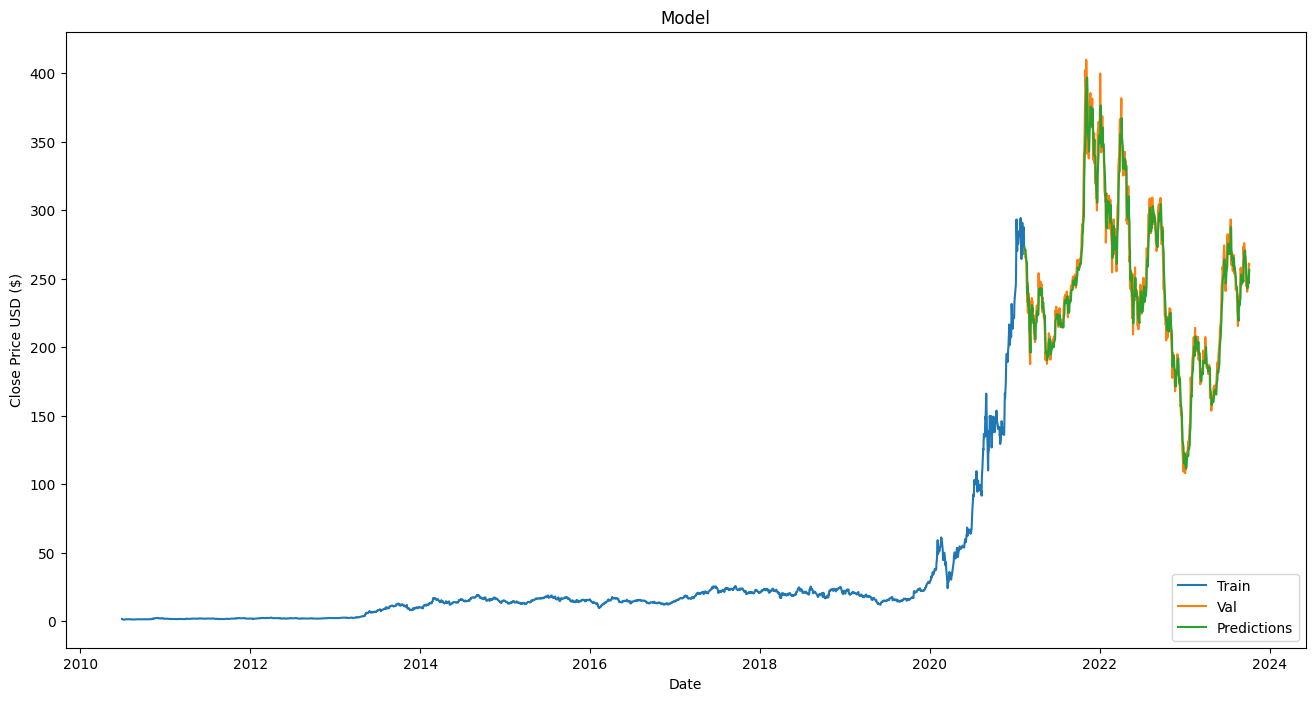

In [130]:
training_data_len = math.ceil(len(y)* 0.8)
data = df_lstm.filter(['Close'])
train = data[:training_data_len]
lstm_predictions = best_model.predict(x_test) #try this for cnn
lstm_predictions = scaler.inverse_transform(lstm_predictions)
validation = data[training_data_len:]
validation['Predictions'] = lstm_predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Unreal. The predictions and validation data are almost indistinguishable from one another. Thus, our LSTM model follows the TSLA stock trends the best and we will further analyze its results to answer the questions we set out to in the contents of my final report

Save the best model

In [131]:
# best_model.save('models/final_lstm.h5')
best_model.save('models/lstm')

INFO:tensorflow:Assets written to: models/lstm/assets


INFO:tensorflow:Assets written to: models/lstm/assets


# Results

Final dataframe with all the models' prediction outputs

In [132]:
df_final

,Close,Volume,RSI,Standard Linear,Standard Polynomial,Default LASSO,Tuned LASSO,Default Ridge,Tuned Ridge,Convolutional Neural Network,LSTM
Date,,,,,,,,,,,
2010-06-29 00:00:00-04:00,1.592667,281494500,53.239359,-63.559243,-7.953792,22.984853,13.131017,36.921713,36.921713,1.592634,NaN
2010-06-30 00:00:00-04:00,1.588667,257806500,53.239359,-63.504886,-7.949894,22.942096,13.125846,36.635116,36.635116,1.588633,NaN
2010-07-01 00:00:00-04:00,1.464000,123282000,53.239359,-63.450528,-7.945993,22.899368,13.120642,36.349549,36.349549,1.463934,NaN
2010-07-02 00:00:00-04:00,1.280000,77097000,53.239359,-63.396170,-7.942088,22.856668,13.115403,36.065009,36.065009,1.279888,NaN
2010-07-06 00:00:00-04:00,1.074000,103003500,53.239359,-63.178738,-7.926427,22.686149,13.094106,34.937082,34.937082,1.073835,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02 00:00:00-04:00,251.600006,123810400,49.117057,199.695872,323.226212,307.516769,297.249394,178.077113,178.077113,251.599991,247.941803
2023-10-03 00:00:00-04:00,246.529999,101985300,45.742195,199.750230,323.499159,307.720447,297.406209,177.553621,177.553621,246.529968,249.615204
2023-10-04 00:00:00-04:00,261.160004,129721600,55.289011,199.804588,323.772314,307.924209,297.563009,177.028307,177.028307,261.160004,247.062454


Final plots of all the models' testing set performances

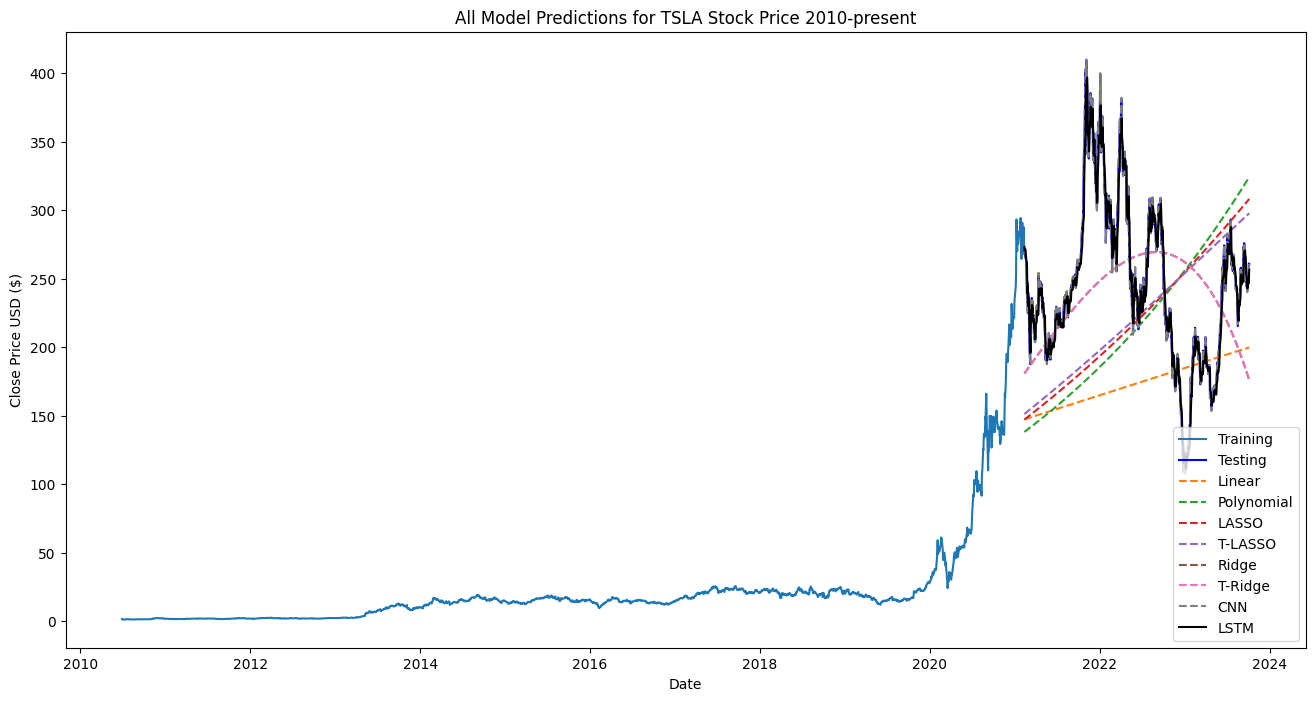

In [133]:
data = df_final.filter(['Close'])
train = data[:training_data_len]
df_final_validation = df_final[training_data_len:]

plt.figure(figsize=(16,8))
plt.title('All Model Predictions for TSLA Stock Price 2010-present')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(df_final_validation['Close'], color='b')
plt.plot(df_final_validation[['Standard Linear', 'Standard Polynomial','Default LASSO',
                              'Tuned LASSO', 'Default Ridge', 'Tuned Ridge', 'Convolutional Neural Network']], linestyle='dashed')
plt.plot(df_final_validation['LSTM'], color='k')
plt.legend(['Training', 'Testing', 'Linear', 'Polynomial', 'LASSO', 'T-LASSO', 'Ridge', 'T-Ridge', 'CNN', 'LSTM'], loc='lower right')
plt.show()

Final Training and Testing performances of all the models using coefficient of determination

| | Training Error  | Testing Error    |
|---:|:-------------|:-----------|
| Linear Regression | 0.517265456656931  | 0.5461865662332489       |
| Polynomial Regresison | 0.7943952137323822  | 0.8062219370202884    |
| Default LASSO Regression | 0.8091500174548129  | 0.821587665238023       |
| Tuned LASSO Regression | 0.8471021545948261  | 0.8444999551173105       |
| Default Ridge Regression | 0.8903719702340803  | 0.8977066829828838    |
| Tuned Ridge Regression | 0.8903719702340803  | 0.8977066829828838       |
| Convolutional Neural Network | 0.9853692355315851  | 0.9486862726707382    |
| LSTM RNN (Final Model) | 0.9934396328367727  | 0.9801493406579797       |

Now lets do something really interesting and use the last bits of data we have, along with the prediction closing price values for future dates themselves whenever encountering an absence of such prices, to predict the upcoming year's worth of TSLA stock prices. Though we have no way of knowing how close they get to the true values, as we saw with the phenomenal ability of our final LSTM model to generalize the trajectory of a stock, we can see with some confidence where the stock might go

In [ ]:
# offset = 365
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(y.reshape(-1,1))
# x_train, y_train, x_test, y_test = data_split(y, scaler, offset)

In [ ]:
# test_data = scaled_data[training_data_len-offset: , : ]
# x_test = []
# y_test = scaled_data[training_data_len:]
# for i in range(offset, len(test_data)):
#   x_test.append(test_data[i-offset:i, 0])
# x_test = np.array(x_test)
# print(x_test)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# return x_train, y_train, x_test, y_test

In [134]:
import datetime

scaled_data = scaler.fit_transform( df_final['Close'].values.reshape(-1,1) )
data = df_final.filter(['Close'])
for i in range(offset):
  # Set next_day to be the last index plus 24 hours, past_30 to be the close
  # price of the last 30 days, and pred to be the prediction based off that
  next_day = data.index[-1] + datetime.timedelta(days=1)
  past_x_days = []
  past_x_days.append( scaled_data[-offset:, 0] )
  past_x_days = np.array( past_x_days )
  # print("past_30", past_30)
  past_x_days = np.reshape(past_x_days, (1, offset, 1))

  pred = best_model.predict( past_x_days )
  pred = scaler.inverse_transform(pred)
  pred = pred[0][0]
  print("predicted value: ", pred)

  # Append the new date-price prow to our data series
  new_row = pd.DataFrame(columns=['Date', 'Close'])
  new_row.loc[0] = [next_day, pred]
  new_row.set_index('Date', inplace=True)
  data = pd.concat([data, new_row], ignore_index = False)
  scaled_data = scaler.fit_transform( data['Close'].values.reshape(-1,1) )
display(data)

1/1 [==============================] - 0s 115ms/step
predicted value:  257.46246
1/1 [==============================] - 0s 101ms/step
predicted value:  255.99536
1/1 [==============================] - 0s 45ms/step
predicted value:  254.6179
1/1 [==============================] - 0s 37ms/step
predicted value:  253.46628
1/1 [==============================] - 0s 37ms/step
predicted value:  252.52129
1/1 [==============================] - 0s 36ms/step
predicted value:  251.72673
1/1 [==============================] - 0s 72ms/step
predicted value:  251.02534
1/1 [==============================] - 0s 153ms/step
predicted value:  250.37164
1/1 [==============================] - 0s 64ms/step
predicted value:  249.73526
1/1 [==============================] - 0s 54ms/step
predicted value:  249.09904
1/1 [==============================] - 0s 50ms/step
predicted value:  248.45558
1/1 [==============================] - 0s 49ms/step
predicted value:  247.8035
1/1 [==============================] - 

,Close
Date,
2010-06-29 00:00:00-04:00,1.592667
2010-06-30 00:00:00-04:00,1.588667
2010-07-01 00:00:00-04:00,1.464000
2010-07-02 00:00:00-04:00,1.280000
2010-07-06 00:00:00-04:00,1.074000
...,...
2023-11-01 00:00:00-04:00,238.578827
2023-11-02 00:00:00-04:00,237.930542
2023-11-03 00:00:00-04:00,237.283676


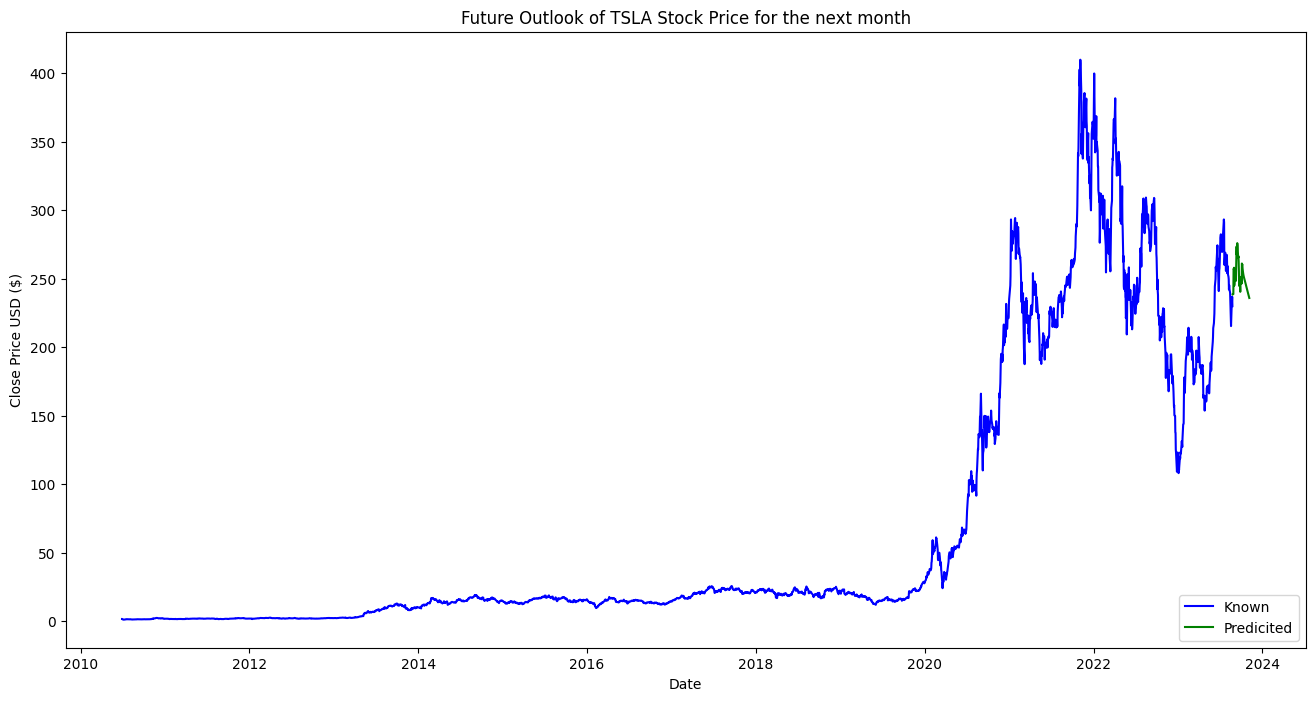

In [135]:
plt.figure(figsize=(16,8))
plt.title('Future Outlook of TSLA Stock Price for the next month')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data[:len(x)], color='b')
plt.plot(data[len(x):], color='g')
plt.legend(['Known', 'Predicited'], loc='lower right')
plt.show()

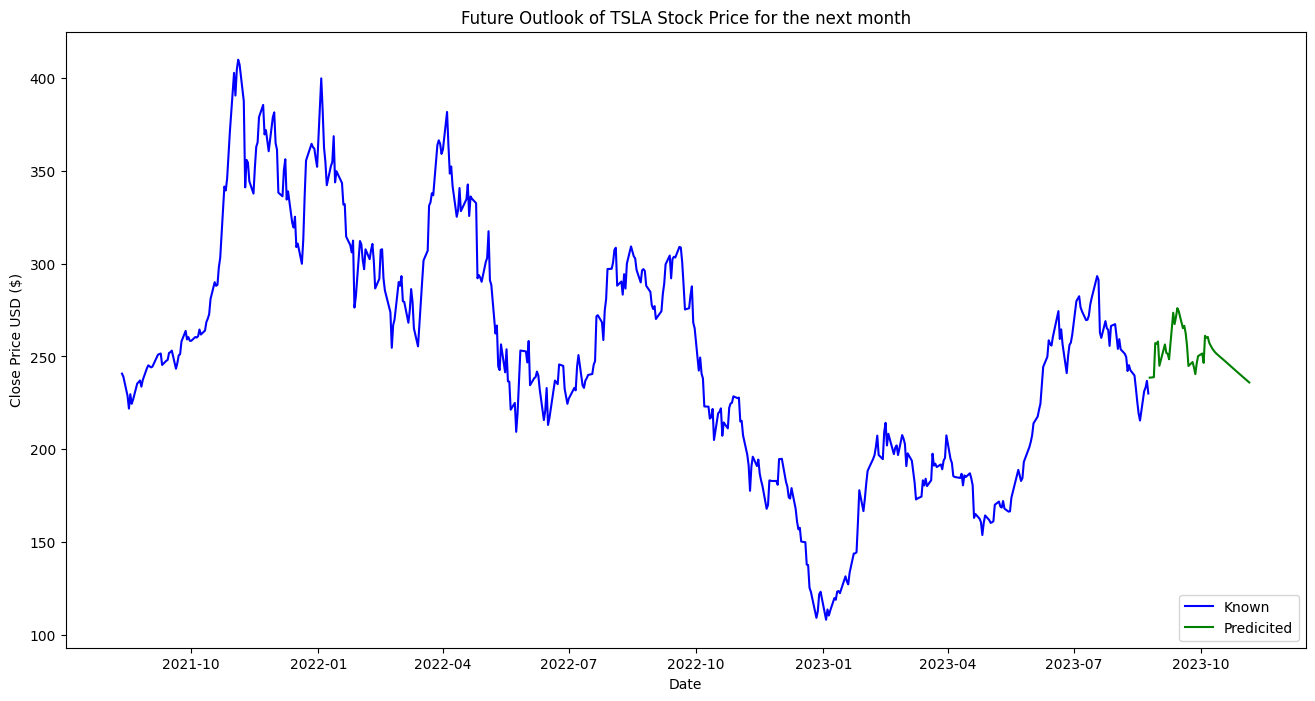

In [136]:
plt.figure(figsize=(16,8))
plt.title('Future Outlook of TSLA Stock Price for the next month')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data[2800:len(x)], color='b')
plt.plot(data[len(x):], color='g')
plt.legend(['Known', 'Predicited'], loc='lower right')
plt.show()